# Project: Wrangling and Analyzing Data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gathering">Gathering Data</a></li>
<li><a href="#assessing">Assessing Data</a></li>    

>    <a href="#issues">Identified Issues</a>
<li><a href="#cleaning">Cleaning Data</a></li>    
<li><a href="#storing">Storing Data </a></li>
<li><a href="#analyzing">Analyzing Data</a></li>
    
> <a href="#insights">Insights</a>    
<li><a href="#visualizing">Visualizing Data</a></li>
</ul>

<a id='intro'></a>
## Introduction

The project involves data from `WeRateDogs` twitter account. Their handle is [@dog_rates](https://twitter.com/dog_rates)      
They celebrate dogs and offer support to dogs in medical emergencies.  
Their tweets are fun and full of cute dog pictures.  
Their tweets are bound to make any tiring day feel great again.

The task is to gather, assess, clean and derive insights from the tweets 


We'll import all the libraries we'll need first.

In [1]:
import re
import json
import numpy as np
import pandas as pd
import tweepy as tp
import requests as rq
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

sns.set()

<a id='gathering'></a>
## Gathering Data

Our data comes from different sources:
- a `csv` file from @dog_rates twitter archives
- a `tsv` file with data on image predictions for dog breed categorizations
- extra data from twitter on the already provided tweets in the `csv` file that will be obtained using a Twitter developer account and Tweepy.

### 1. WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)
We'll read the csv file using `pandas.read_csv`

In [2]:
we_rate_dogs = pd.read_csv('data\twitter-archive-enhanced.csv')
we_rate_dogs.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### 2. Tweet image prediction (image_predictions.tsv)

The data was provided as a `tsv` file in a cloud storage.  
We'll access its contents programmatically using `requests` library then write them into a `tsv` file.  
The file will then be loaded into `pandas` using `pandas.read_csv` with a tab `\t` as the delimiter

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = rq.get(url)

with open('data/image_predictions.tsv', 'wb') as file:
    file.write(response.content)

img_pred = pd.read_csv('data/image_predictions.tsv', sep='\t')
img_pred.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
118,668154635664932864,https://pbs.twimg.com/media/CUXDGR2WcAAUQKz.jpg,1,Arctic_fox,0.473584,False,wallaby,0.261411,False,white_wolf,0.080948,False
405,673707060090052608,https://pbs.twimg.com/media/CVl8_EPWoAAcuSC.jpg,1,German_short-haired_pointer,0.935771,True,kelpie,0.022561,True,Labrador_retriever,0.008847,True
1124,727286334147182592,https://pbs.twimg.com/media/ChfXDrGUkAEAtF-.jpg,1,bonnet,0.146440,False,sock,0.083091,False,Chihuahua,0.070554,True
938,703631701117943808,https://pbs.twimg.com/media/CcPNS4yW8AAd-Et.jpg,2,window_shade,0.909533,False,window_screen,0.011427,False,brass,0.008882,False


### 3. Extra tweet data via Tweepy (tweet_json.txt)

We will be obtaining extra data on the tweets in the provided `csv` file using Twitter's API called `Tweepy`

We'll be using `Twitter V2` which makes use of `Client` rather than `API` of v1

We'll first get the authentication done to enable us access Twitter data.  
The bearer token has been changed for security reasons.  
`wait_on_rate_limit` automatically handles the twitter rate limits.  
Our return type will be `requests.Response` that will enable us to a quick conversion of the response to json.  

##### Reference
- [Jan Kirenz's blog](https://www.kirenz.com/post/2021-12-10-twitter-api-v2-tweepy-and-pandas-in-python/twitter-api-v2-tweepy-and-pandas-in-python/)
- [Tweepy docs](https://docs.tweepy.org/en/stable/client.html#tweepy.Client.get_tweet)
- [Request's docs](https://requests.readthedocs.io/en/stable/api/#requests.Response)

We'll be getting more data on the `tweet ids` in the `we_rate_dogs` dataframe

According to [Twitter documentation](https://developer.twitter.com/en/docs/twitter-api/data-dictionary/object-model/tweet), we can obtain extra tweet data through `tweet_fields`  

The default returned data is: 
+ id
+ text

The extra fields we'll obtain through `public_metrics` tweet field are:
- retweet count
- like count
- quote count
- reply count

Since the data is returned as a `Response`, we'll:
- obtain the underlying dict/json object using `.json()`. Note that jsons are formatted as dicts  
- convert the `dict` to a `str` and drop it into our `tweets_json.txt` file using `json.dump` ie. serialize dict into json-formatted stream

**Note**  
All responses will be decoded into dicts using `.json()`.  
This means that errors too will be represented as dicts.  
There won't be any errors in this stage(decoding the Response) hence no need for `try except`  
The errors will be seen in the dataframe and it will be easy to filter them out from there

In [6]:
# This takes quite a long time. (You can skip it)
# This cell can be skipped if you don't have a twitter developer account set up or 
# if you don't have the time to wait for the extremely long fetch time

bearer_token ='BEARER TOKEN'
client = tp.Client(bearer_token, return_type=rq.Response, wait_on_rate_limit=True)

#get all tweet ids in we_rate_dogs dataframe
tweet_ids = we_rate_dogs.tweet_id.values
count = 0

with open('data/tweet_json.txt', 'w') as file:
    for id_ in tweet_ids:
        count += 1
        print(str(count) + ': ' + str(id_))
        tweet = client.get_tweet(id=id_, tweet_fields='public_metrics')
        print('Tweet data loaded')
        json.dump(tweet.json(), file)
        file.write('\n')
        print('Tweet data in file')

1: 892420643555336193
Tweet data loaded
Tweet data in file
2: 892177421306343426
Tweet data loaded
Tweet data in file
3: 891815181378084864
Tweet data loaded
Tweet data in file
4: 891689557279858688
Tweet data loaded
Tweet data in file
5: 891327558926688256
Tweet data loaded
Tweet data in file
6: 891087950875897856
Tweet data loaded
Tweet data in file
7: 890971913173991426
Tweet data loaded
Tweet data in file
8: 890729181411237888
Tweet data loaded
Tweet data in file
9: 890609185150312448
Tweet data loaded
Tweet data in file
10: 890240255349198849
Tweet data loaded
Tweet data in file
11: 890006608113172480
Tweet data loaded
Tweet data in file
12: 889880896479866881
Tweet data loaded
Tweet data in file
13: 889665388333682689
Tweet data loaded
Tweet data in file
14: 889638837579907072
Tweet data loaded
Tweet data in file
15: 889531135344209921
Tweet data loaded
Tweet data in file
16: 889278841981685760
Tweet data loaded
Tweet data in file
17: 888917238123831296
Tweet data loaded
Tweet da

Tweet data loaded
Tweet data in file
138: 866094527597207552
Tweet data loaded
Tweet data in file
139: 865718153858494464
Tweet data loaded
Tweet data in file
140: 865359393868664832
Tweet data loaded
Tweet data in file
141: 865006731092295680
Tweet data loaded
Tweet data in file
142: 864873206498414592
Tweet data loaded
Tweet data in file
143: 864279568663928832
Tweet data loaded
Tweet data in file
144: 864197398364647424
Tweet data loaded
Tweet data in file
145: 863907417377173506
Tweet data loaded
Tweet data in file
146: 863553081350529029
Tweet data loaded
Tweet data in file
147: 863471782782697472
Tweet data loaded
Tweet data in file
148: 863432100342583297
Tweet data loaded
Tweet data in file
149: 863427515083354112
Tweet data loaded
Tweet data in file
150: 863079547188785154
Tweet data loaded
Tweet data in file
151: 863062471531167744
Tweet data loaded
Tweet data in file
152: 862831371563274240
Tweet data loaded
Tweet data in file
153: 862722525377298433
Tweet data loaded
Tweet 

Tweet data loaded
Tweet data in file
273: 840761248237133825
Tweet data loaded
Tweet data in file
274: 840728873075638272
Tweet data loaded
Tweet data in file
275: 840698636975636481
Tweet data loaded
Tweet data in file
276: 840696689258311684
Tweet data loaded
Tweet data in file
277: 840632337062862849
Tweet data loaded
Tweet data in file
278: 840370681858686976
Tweet data loaded
Tweet data in file
279: 840268004936019968
Tweet data loaded
Tweet data in file
280: 839990271299457024
Tweet data loaded
Tweet data in file
281: 839549326359670784
Tweet data loaded
Tweet data in file
282: 839290600511926273
Tweet data loaded
Tweet data in file
283: 839239871831150596
Tweet data loaded
Tweet data in file
284: 838952994649550848
Tweet data loaded
Tweet data in file
285: 838921590096166913
Tweet data loaded
Tweet data in file
286: 838916489579200512
Tweet data loaded
Tweet data in file
287: 838831947270979586
Tweet data loaded
Tweet data in file
288: 838561493054533637
Tweet data loaded
Tweet 

Rate limit exceeded. Sleeping for 107 seconds.


Tweet data loaded
Tweet data in file
293: 838083903487373313
Tweet data loaded
Tweet data in file
294: 837820167694528512
Tweet data loaded
Tweet data in file
295: 837482249356513284
Tweet data loaded
Tweet data in file
296: 837471256429613056
Tweet data loaded
Tweet data in file
297: 837366284874571778
Tweet data loaded
Tweet data in file
298: 837110210464448512
Tweet data loaded
Tweet data in file
299: 837012587749474308
Tweet data loaded
Tweet data in file
300: 836989968035819520
Tweet data loaded
Tweet data in file
301: 836753516572119041
Tweet data loaded
Tweet data in file
302: 836677758902222849
Tweet data loaded
Tweet data in file
303: 836648853927522308
Tweet data loaded
Tweet data in file
304: 836397794269200385
Tweet data loaded
Tweet data in file
305: 836380477523124226
Tweet data loaded
Tweet data in file
306: 836260088725786625
Tweet data loaded
Tweet data in file
307: 836001077879255040
Tweet data loaded
Tweet data in file
308: 835685285446955009
Tweet data loaded
Tweet 

Tweet data loaded
Tweet data in file
428: 821153421864615936
Tweet data loaded
Tweet data in file
429: 821149554670182400
Tweet data loaded
Tweet data in file
430: 821107785811234820
Tweet data loaded
Tweet data in file
431: 821044531881721856
Tweet data loaded
Tweet data in file
432: 820837357901512704
Tweet data loaded
Tweet data in file
433: 820749716845686786
Tweet data loaded
Tweet data in file
434: 820690176645140481
Tweet data loaded
Tweet data in file
435: 820494788566847489
Tweet data loaded
Tweet data in file
436: 820446719150292993
Tweet data loaded
Tweet data in file
437: 820314633777061888
Tweet data loaded
Tweet data in file
438: 820078625395449857
Tweet data loaded
Tweet data in file
439: 820013781606658049
Tweet data loaded
Tweet data in file
440: 819952236453363712
Tweet data loaded
Tweet data in file
441: 819924195358416896
Tweet data loaded
Tweet data in file
442: 819711362133872643
Tweet data loaded
Tweet data in file
443: 819588359383371776
Tweet data loaded
Tweet 

Tweet data loaded
Tweet data in file
563: 802600418706604034
Tweet data loaded
Tweet data in file
564: 802572683846291456
Tweet data loaded
Tweet data in file
565: 802323869084381190
Tweet data loaded
Tweet data in file
566: 802265048156610565
Tweet data loaded
Tweet data in file
567: 802247111496568832
Tweet data loaded
Tweet data in file
568: 802239329049477120
Tweet data loaded
Tweet data in file
569: 802185808107208704
Tweet data loaded
Tweet data in file
570: 801958328846974976
Tweet data loaded
Tweet data in file
571: 801854953262350336
Tweet data loaded
Tweet data in file
572: 801538201127157760
Tweet data loaded
Tweet data in file
573: 801285448605831168
Tweet data loaded
Tweet data in file
574: 801167903437357056
Tweet data loaded
Tweet data in file
575: 801127390143516673
Tweet data loaded
Tweet data in file
576: 801115127852503040
Tweet data loaded
Tweet data in file
577: 800859414831898624
Tweet data loaded
Tweet data in file
578: 800855607700029440
Tweet data loaded
Tweet 

Rate limit exceeded. Sleeping for 668 seconds.


Tweet data loaded
Tweet data in file
593: 798933969379225600
Tweet data loaded
Tweet data in file
594: 798925684722855936
Tweet data loaded
Tweet data in file
595: 798705661114773508
Tweet data loaded
Tweet data in file
596: 798701998996647937
Tweet data loaded
Tweet data in file
597: 798697898615730177
Tweet data loaded
Tweet data in file
598: 798694562394996736
Tweet data loaded
Tweet data in file
599: 798686750113755136
Tweet data loaded
Tweet data in file
600: 798682547630837760
Tweet data loaded
Tweet data in file
601: 798673117451325440
Tweet data loaded
Tweet data in file
602: 798665375516884993
Tweet data loaded
Tweet data in file
603: 798644042770751489
Tweet data loaded
Tweet data in file
604: 798628517273620480
Tweet data loaded
Tweet data in file
605: 798585098161549313
Tweet data loaded
Tweet data in file
606: 798576900688019456
Tweet data loaded
Tweet data in file
607: 798340744599797760
Tweet data loaded
Tweet data in file
608: 798209839306514432
Tweet data loaded
Tweet 

Tweet data loaded
Tweet data in file
728: 782305867769217024
Tweet data loaded
Tweet data in file
729: 782021823840026624
Tweet data loaded
Tweet data in file
730: 781955203444699136
Tweet data loaded
Tweet data in file
731: 781661882474196992
Tweet data loaded
Tweet data in file
732: 781655249211752448
Tweet data loaded
Tweet data in file
733: 781524693396357120
Tweet data loaded
Tweet data in file
734: 781308096455073793
Tweet data loaded
Tweet data in file
735: 781251288990355457
Tweet data loaded
Tweet data in file
736: 781163403222056960
Tweet data loaded
Tweet data in file
737: 780931614150983680
Tweet data loaded
Tweet data in file
738: 780858289093574656
Tweet data loaded
Tweet data in file
739: 780800785462489090
Tweet data loaded
Tweet data in file
740: 780601303617732608
Tweet data loaded
Tweet data in file
741: 780543529827336192
Tweet data loaded
Tweet data in file
742: 780496263422808064
Tweet data loaded
Tweet data in file
743: 780476555013349377
Tweet data loaded
Tweet 

Tweet data loaded
Tweet data in file
863: 762699858130116608
Tweet data loaded
Tweet data in file
864: 762471784394268675
Tweet data loaded
Tweet data in file
865: 762464539388485633
Tweet data loaded
Tweet data in file
866: 762316489655476224
Tweet data loaded
Tweet data in file
867: 762035686371364864
Tweet data loaded
Tweet data in file
868: 761976711479193600
Tweet data loaded
Tweet data in file
869: 761750502866649088
Tweet data loaded
Tweet data in file
870: 761745352076779520
Tweet data loaded
Tweet data in file
871: 761672994376806400
Tweet data loaded
Tweet data in file
872: 761599872357261312
Tweet data loaded
Tweet data in file
873: 761371037149827077
Tweet data loaded
Tweet data in file
874: 761334018830917632
Tweet data loaded
Tweet data in file
875: 761292947749015552
Tweet data loaded
Tweet data in file
876: 761227390836215808
Tweet data loaded
Tweet data in file
877: 761004547850530816
Tweet data loaded
Tweet data in file
878: 760893934457552897
Tweet data loaded
Tweet 

Rate limit exceeded. Sleeping for 668 seconds.


Tweet data loaded
Tweet data in file
893: 759447681597108224
Tweet data loaded
Tweet data in file
894: 759446261539934208
Tweet data loaded
Tweet data in file
895: 759197388317847553
Tweet data loaded
Tweet data in file
896: 759159934323924993
Tweet data loaded
Tweet data in file
897: 759099523532779520
Tweet data loaded
Tweet data in file
898: 759047813560868866
Tweet data loaded
Tweet data in file
899: 758854675097526272
Tweet data loaded
Tweet data in file
900: 758828659922702336
Tweet data loaded
Tweet data in file
901: 758740312047005698
Tweet data loaded
Tweet data in file
902: 758474966123810816
Tweet data loaded
Tweet data in file
903: 758467244762497024
Tweet data loaded
Tweet data in file
904: 758405701903519748
Tweet data loaded
Tweet data in file
905: 758355060040593408
Tweet data loaded
Tweet data in file
906: 758099635764359168
Tweet data loaded
Tweet data in file
907: 758041019896193024
Tweet data loaded
Tweet data in file
908: 757741869644341248
Tweet data loaded
Tweet 

Tweet data loaded
Tweet data in file
1027: 746131877086527488
Tweet data loaded
Tweet data in file
1028: 746056683365994496
Tweet data loaded
Tweet data in file
1029: 745789745784041472
Tweet data loaded
Tweet data in file
1030: 745712589599014916
Tweet data loaded
Tweet data in file
1031: 745433870967832576
Tweet data loaded
Tweet data in file
1032: 745422732645535745
Tweet data loaded
Tweet data in file
1033: 745314880350101504
Tweet data loaded
Tweet data in file
1034: 745074613265149952
Tweet data loaded
Tweet data in file
1035: 745057283344719872
Tweet data loaded
Tweet data in file
1036: 744995568523612160
Tweet data loaded
Tweet data in file
1037: 744971049620602880
Tweet data loaded
Tweet data in file
1038: 744709971296780288
Tweet data loaded
Tweet data in file
1039: 744334592493166593
Tweet data loaded
Tweet data in file
1040: 744234799360020481
Tweet data loaded
Tweet data in file
1041: 744223424764059648
Tweet data loaded
Tweet data in file
1042: 743980027717509120
Tweet da

Tweet data loaded
Tweet data in file
1160: 724046343203856385
Tweet data loaded
Tweet data in file
1161: 724004602748780546
Tweet data loaded
Tweet data in file
1162: 723912936180330496
Tweet data loaded
Tweet data in file
1163: 723688335806480385
Tweet data loaded
Tweet data in file
1164: 723673163800948736
Tweet data loaded
Tweet data in file
1165: 723179728551723008
Tweet data loaded
Tweet data in file
1166: 722974582966214656
Tweet data loaded
Tweet data in file
1167: 722613351520608256
Tweet data loaded
Tweet data in file
1168: 721503162398597120
Tweet data loaded
Tweet data in file
1169: 721001180231503872
Tweet data loaded
Tweet data in file
1170: 720785406564900865
Tweet data loaded
Tweet data in file
1171: 720775346191278080
Tweet data loaded
Tweet data in file
1172: 720415127506415616
Tweet data loaded
Tweet data in file
1173: 720389942216527872
Tweet data loaded
Tweet data in file
1174: 720340705894408192
Tweet data loaded
Tweet data in file
1175: 720059472081784833
Tweet da

Rate limit exceeded. Sleeping for 662 seconds.


Tweet data loaded
Tweet data in file
1193: 717790033953034240
Tweet data loaded
Tweet data in file
1194: 717537687239008257
Tweet data loaded
Tweet data in file
1195: 717428917016076293
Tweet data loaded
Tweet data in file
1196: 717421804990701568
Tweet data loaded
Tweet data in file
1197: 717047459982213120
Tweet data loaded
Tweet data in file
1198: 717009362452090881
Tweet data loaded
Tweet data in file
1199: 716802964044845056
Tweet data loaded
Tweet data in file
1200: 716791146589110272
Tweet data loaded
Tweet data in file
1201: 716730379797970944
Tweet data loaded
Tweet data in file
1202: 716447146686459905
Tweet data loaded
Tweet data in file
1203: 716439118184652801
Tweet data loaded
Tweet data in file
1204: 716285507865542656
Tweet data loaded
Tweet data in file
1205: 716080869887381504
Tweet data loaded
Tweet data in file
1206: 715928423106027520
Tweet data loaded
Tweet data in file
1207: 715758151270801409
Tweet data loaded
Tweet data in file
1208: 715733265223708672
Tweet da

Tweet data loaded
Tweet data in file
1326: 706166467411222528
Tweet data loaded
Tweet data in file
1327: 706153300320784384
Tweet data loaded
Tweet data in file
1328: 705975130514706432
Tweet data loaded
Tweet data in file
1329: 705970349788291072
Tweet data loaded
Tweet data in file
1330: 705898680587526145
Tweet data loaded
Tweet data in file
1331: 705786532653883392
Tweet data loaded
Tweet data in file
1332: 705591895322394625
Tweet data loaded
Tweet data in file
1333: 705475953783398401
Tweet data loaded
Tweet data in file
1334: 705442520700944385
Tweet data loaded
Tweet data in file
1335: 705428427625635840
Tweet data loaded
Tweet data in file
1336: 705239209544720384
Tweet data loaded
Tweet data in file
1337: 705223444686888960
Tweet data loaded
Tweet data in file
1338: 705102439679201280
Tweet data loaded
Tweet data in file
1339: 705066031337840642
Tweet data loaded
Tweet data in file
1340: 704871453724954624
Tweet data loaded
Tweet data in file
1341: 704859558691414016
Tweet da

Tweet data loaded
Tweet data in file
1459: 695074328191332352
Tweet data loaded
Tweet data in file
1460: 695064344191721472
Tweet data loaded
Tweet data in file
1461: 695051054296211456
Tweet data loaded
Tweet data in file
1462: 694925794720792577
Tweet data loaded
Tweet data in file
1463: 694905863685980160
Tweet data loaded
Tweet data in file
1464: 694669722378485760
Tweet data loaded
Tweet data in file
1465: 694356675654983680
Tweet data loaded
Tweet data in file
1466: 694352839993344000
Tweet data loaded
Tweet data in file
1467: 694342028726001664
Tweet data loaded
Tweet data in file
1468: 694329668942569472
Tweet data loaded
Tweet data in file
1469: 694206574471057408
Tweet data loaded
Tweet data in file
1470: 694183373896572928
Tweet data loaded
Tweet data in file
1471: 694001791655137281
Tweet data loaded
Tweet data in file
1472: 693993230313091072
Tweet data loaded
Tweet data in file
1473: 693942351086120961
Tweet data loaded
Tweet data in file
1474: 693647888581312512
Tweet da

Rate limit exceeded. Sleeping for 665 seconds.


Tweet data loaded
Tweet data in file
1493: 692828166163931137
Tweet data loaded
Tweet data in file
1494: 692752401762250755
Tweet data loaded
Tweet data in file
1495: 692568918515392513
Tweet data loaded
Tweet data in file
1496: 692535307825213440
Tweet data loaded
Tweet data in file
1497: 692530551048294401
Tweet data loaded
Tweet data in file
1498: 692423280028966913
Tweet data loaded
Tweet data in file
1499: 692417313023332352
Tweet data loaded
Tweet data in file
1500: 692187005137076224
Tweet data loaded
Tweet data in file
1501: 692158366030913536
Tweet data loaded
Tweet data in file
1502: 692142790915014657
Tweet data loaded
Tweet data in file
1503: 692041934689402880
Tweet data loaded
Tweet data in file
1504: 692017291282812928
Tweet data loaded
Tweet data in file
1505: 691820333922455552
Tweet data loaded
Tweet data in file
1506: 691793053716221953
Tweet data loaded
Tweet data in file
1507: 691756958957883396
Tweet data loaded
Tweet data in file
1508: 691675652215414786
Tweet da

Tweet data loaded
Tweet data in file
1626: 684830982659280897
Tweet data loaded
Tweet data in file
1627: 684800227459624960
Tweet data loaded
Tweet data in file
1628: 684594889858887680
Tweet data loaded
Tweet data in file
1629: 684588130326986752
Tweet data loaded
Tweet data in file
1630: 684567543613382656
Tweet data loaded
Tweet data in file
1631: 684538444857667585
Tweet data loaded
Tweet data in file
1632: 684481074559381504
Tweet data loaded
Tweet data in file
1633: 684460069371654144
Tweet data loaded
Tweet data in file
1634: 684241637099323392
Tweet data loaded
Tweet data in file
1635: 684225744407494656
Tweet data loaded
Tweet data in file
1636: 684222868335505415
Tweet data loaded
Tweet data in file
1637: 684200372118904832
Tweet data loaded
Tweet data in file
1638: 684195085588783105
Tweet data loaded
Tweet data in file
1639: 684188786104872960
Tweet data loaded
Tweet data in file
1640: 684177701129875456
Tweet data loaded
Tweet data in file
1641: 684147889187209216
Tweet da

Tweet data loaded
Tweet data in file
1759: 678755239630127104
Tweet data loaded
Tweet data in file
1760: 678740035362037760
Tweet data loaded
Tweet data in file
1761: 678708137298427904
Tweet data loaded
Tweet data in file
1762: 678675843183484930
Tweet data loaded
Tweet data in file
1763: 678643457146150913
Tweet data loaded
Tweet data in file
1764: 678446151570427904
Tweet data loaded
Tweet data in file
1765: 678424312106393600
Tweet data loaded
Tweet data in file
1766: 678410210315247616
Tweet data loaded
Tweet data in file
1767: 678399652199309312
Tweet data loaded
Tweet data in file
1768: 678396796259975168
Tweet data loaded
Tweet data in file
1769: 678389028614488064
Tweet data loaded
Tweet data in file
1770: 678380236862578688
Tweet data loaded
Tweet data in file
1771: 678341075375947776
Tweet data loaded
Tweet data in file
1772: 678334497360859136
Tweet data loaded
Tweet data in file
1773: 678278586130948096
Tweet data loaded
Tweet data in file
1774: 678255464182861824
Tweet da

Rate limit exceeded. Sleeping for 666 seconds.


Tweet data loaded
Tweet data in file
1793: 677334615166730240
Tweet data loaded
Tweet data in file
1794: 677331501395156992
Tweet data loaded
Tweet data in file
1795: 677328882937298944
Tweet data loaded
Tweet data in file
1796: 677314812125323265
Tweet data loaded
Tweet data in file
1797: 677301033169788928
Tweet data loaded
Tweet data in file
1798: 677269281705472000
Tweet data loaded
Tweet data in file
1799: 677228873407442944
Tweet data loaded
Tweet data in file
1800: 677187300187611136
Tweet data loaded
Tweet data in file
1801: 676975532580409345
Tweet data loaded
Tweet data in file
1802: 676957860086095872
Tweet data loaded
Tweet data in file
1803: 676949632774234114
Tweet data loaded
Tweet data in file
1804: 676948236477857792
Tweet data loaded
Tweet data in file
1805: 676946864479084545
Tweet data loaded
Tweet data in file
1806: 676942428000112642
Tweet data loaded
Tweet data in file
1807: 676936541936185344
Tweet data loaded
Tweet data in file
1808: 676916996760600576
Tweet da

Tweet data loaded
Tweet data in file
1926: 674063288070742018
Tweet data loaded
Tweet data in file
1927: 674053186244734976
Tweet data loaded
Tweet data in file
1928: 674051556661161984
Tweet data loaded
Tweet data in file
1929: 674045139690631169
Tweet data loaded
Tweet data in file
1930: 674042553264685056
Tweet data loaded
Tweet data in file
1931: 674038233588723717
Tweet data loaded
Tweet data in file
1932: 674036086168010753
Tweet data loaded
Tweet data in file
1933: 674024893172875264
Tweet data loaded
Tweet data in file
1934: 674019345211760640
Tweet data loaded
Tweet data in file
1935: 674014384960745472
Tweet data loaded
Tweet data in file
1936: 674008982932058114
Tweet data loaded
Tweet data in file
1937: 673956914389192708
Tweet data loaded
Tweet data in file
1938: 673919437611909120
Tweet data loaded
Tweet data in file
1939: 673906403526995968
Tweet data loaded
Tweet data in file
1940: 673887867907739649
Tweet data loaded
Tweet data in file
1941: 673716320723169284
Tweet da

Tweet data loaded
Tweet data in file
2059: 671347597085433856
Tweet data loaded
Tweet data in file
2060: 671186162933985280
Tweet data loaded
Tweet data in file
2061: 671182547775299584
Tweet data loaded
Tweet data in file
2062: 671166507850801152
Tweet data loaded
Tweet data in file
2063: 671163268581498880
Tweet data loaded
Tweet data in file
2064: 671159727754231808
Tweet data loaded
Tweet data in file
2065: 671154572044468225
Tweet data loaded
Tweet data in file
2066: 671151324042559489
Tweet data loaded
Tweet data in file
2067: 671147085991960577
Tweet data loaded
Tweet data in file
2068: 671141549288370177
Tweet data loaded
Tweet data in file
2069: 671138694582165504
Tweet data loaded
Tweet data in file
2070: 671134062904504320
Tweet data loaded
Tweet data in file
2071: 671122204919246848
Tweet data loaded
Tweet data in file
2072: 671115716440031232
Tweet data loaded
Tweet data in file
2073: 671109016219725825
Tweet data loaded
Tweet data in file
2074: 670995969505435648
Tweet da

Rate limit exceeded. Sleeping for 668 seconds.


Tweet data loaded
Tweet data in file
2093: 670782429121134593
Tweet data loaded
Tweet data in file
2094: 670780561024270336
Tweet data loaded
Tweet data in file
2095: 670778058496974848
Tweet data loaded
Tweet data in file
2096: 670764103623966721
Tweet data loaded
Tweet data in file
2097: 670755717859713024
Tweet data loaded
Tweet data in file
2098: 670733412878163972
Tweet data loaded
Tweet data in file
2099: 670727704916926465
Tweet data loaded
Tweet data in file
2100: 670717338665226240
Tweet data loaded
Tweet data in file
2101: 670704688707301377
Tweet data loaded
Tweet data in file
2102: 670691627984359425
Tweet data loaded
Tweet data in file
2103: 670679630144274432
Tweet data loaded
Tweet data in file
2104: 670676092097810432
Tweet data loaded
Tweet data in file
2105: 670668383499735048
Tweet data loaded
Tweet data in file
2106: 670474236058800128
Tweet data loaded
Tweet data in file
2107: 670468609693655041
Tweet data loaded
Tweet data in file
2108: 670465786746662913
Tweet da

Tweet data loaded
Tweet data in file
2226: 668286279830867968
Tweet data loaded
Tweet data in file
2227: 668274247790391296
Tweet data loaded
Tweet data in file
2228: 668268907921326080
Tweet data loaded
Tweet data in file
2229: 668256321989451776
Tweet data loaded
Tweet data in file
2230: 668248472370458624
Tweet data loaded
Tweet data in file
2231: 668237644992782336
Tweet data loaded
Tweet data in file
2232: 668226093875376128
Tweet data loaded
Tweet data in file
2233: 668221241640230912
Tweet data loaded
Tweet data in file
2234: 668204964695683073
Tweet data loaded
Tweet data in file
2235: 668190681446379520
Tweet data loaded
Tweet data in file
2236: 668171859951755264
Tweet data loaded
Tweet data in file
2237: 668154635664932864
Tweet data loaded
Tweet data in file
2238: 668142349051129856
Tweet data loaded
Tweet data in file
2239: 668113020489474048
Tweet data loaded
Tweet data in file
2240: 667937095915278337
Tweet data loaded
Tweet data in file
2241: 667924896115245057
Tweet da

We'll now get our data from the `tweet_json.txt` file and for each line in the file:
- load the string(json-formatted stream) and deserialize it into a dict using `json.loads`
- load the dict into a pandas DataFrame using pd.json_normalize() 
- append each new row of data into the dataframe.

When all rows are loaded, we'll:
- reset the indices
- view a part of the dataframe

In [4]:
with open('data/tweet_json.txt', 'r') as file:
    extra_tw_data = None
    for line in file:
        data = json.loads(line)
        extra_tw_data1 = pd.json_normalize(data, errors='ignore')
        extra_tw_data = pd.concat([extra_tw_data, extra_tw_data1])        
extra_tw_data.reset_index(inplace=True, drop=True)
extra_tw_data.head()

,data.id,data.public_metrics.retweet_count,data.public_metrics.reply_count,data.public_metrics.like_count,data.public_metrics.quote_count,data.text,errors
0,892420643555336193,6961.0,139.0,33638.0,219.0,This is Phineas. He's a mystical boy. Only eve...,NaN
1,892177421306343426,5265.0,170.0,29180.0,274.0,This is Tilly. She's just checking pup on you....,NaN
2,891815181378084864,3463.0,110.0,21949.0,145.0,This is Archie. He is a rare Norwegian Pouncin...,NaN
3,891689557279858688,7175.0,142.0,36709.0,286.0,This is Darla. She commenced a snooze mid meal...,NaN
4,891327558926688256,7707.0,193.0,35103.0,296.0,This is Franklin. He would like you to stop ca...,NaN


<a id='assessing'></a>
## Assessing Data

We'll now look through our data to see what quality or tidiness issues it has and document them

### 1. We Rate Dogs DataFrame

#### Visual Assessment

In [5]:
we_rate_dogs.sample(15)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
246,845677943972139009,NaN,NaN,2017-03-25 16:45:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",C'mon guys. Please only send in dogs. We only ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/845677943...,12,10,None,None,None,None,None
323,834089966724603904,NaN,NaN,2017-02-21 17:18:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",DOGGO ON THE LOOSE I REPEAT DOGGO ON THE LOOSE...,NaN,NaN,NaN,https://twitter.com/stevekopack/status/8340866...,10,10,None,doggo,None,None,None
1078,739485634323156992,NaN,NaN,2016-06-05 15:54:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kyle. He's a heavy drinker and an avid...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/739485634...,6,10,Kyle,None,None,None,None
1887,674788554665512960,NaN,NaN,2015-12-10 03:11:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Maggie. She's a Western Septic Do...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674788554...,9,10,Maggie,None,None,None,None
656,791780927877898241,NaN,NaN,2016-10-27 23:17:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Maddie. She gets some w...,7.467577e+17,4.196984e+09,2016-06-25 17:31:25 +0000,"https://vine.co/v/5BYq6hmrEI3,https://vine.co/...",11,10,Maddie,None,None,None,None
1197,717009362452090881,NaN,NaN,2016-04-04 15:22:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Smokey. He's having some sort of exist...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/717009362...,10,10,Smokey,None,None,pupper,None
1117,732375214819057664,NaN,NaN,2016-05-17 01:00:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kyle (pronounced 'Mitch'). He strives ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/732375214...,11,10,Kyle,doggo,None,None,None
233,847842811428974592,NaN,NaN,2017-03-31 16:07:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Rontu. He is described as a pal, cuddl...",NaN,NaN,NaN,"https://www.gofundme.com/help-save-rontu,https...",12,10,Rontu,None,None,None,None
1163,723673163800948736,NaN,NaN,2016-04-23 00:41:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Ivar. She is a badass Viking warrior. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/723673163...,10,10,Ivar,None,None,None,None
1632,684460069371654144,NaN,NaN,2016-01-05 19:42:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jeph. He's a Western Sagittarius Dookm...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684460069...,10,10,Jeph,None,None,None,None


#### Programmatic Assessment

Let's get a view of our column information

In [6]:
we_rate_dogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

###### What do our ratings look like?

In [7]:
we_rate_dogs.rating_numerator.unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88], dtype=int64)

In [8]:
we_rate_dogs.rating_denominator.unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2], dtype=int64)

###### What are the names like?

In [9]:
we_rate_dogs.name.sort_values(ascending=False).unique()

array(['very', 'unacceptable', 'this', 'the', 'such', 'space', 'quite',
       'one', 'old', 'officially', 'not', 'my', 'mad', 'light', 'life',
       'just', 'infuriating', 'incredibly', 'his', 'getting', 'by', 'an',
       'all', 'actually', 'a', 'Zuzu', 'Zooey', 'Zoey', 'Zoe', 'Ziva',
       'Zeus', 'Zeke', 'Zeek', 'Zara', 'Yukon', 'Yogi', 'Yoda', 'Wyatt',
       'Wishes', 'Winston', 'Winnie', 'Winifred', 'Wilson', 'Willy',
       'Willow', 'Willie', 'William', 'Willem', 'Wiggles', 'Wesley',
       'Watson', 'Walter', 'Wally', 'Wallace', 'Walker', 'Waffles',
       'Wafer', 'Vixen', 'Vinscent', 'Vinnie', 'Vincent', 'Vince',
       'Venti', 'Ulysses', 'Tyrus', 'Tyrone', 'Tyr', 'Tycho', 'Tupawc',
       'Tug', 'Tuco', 'Tucker', 'Tuck', 'Trooper', 'Tripp', 'Trip',
       'Trigger', 'Trevith', 'Traviss', 'Travis', 'Tove', 'Torque',
       'Tonks', 'Tommy', 'Tom', 'Toffee', 'Todo', 'Toby', 'Tobi', 'Tito',
       'Titan', 'Tino', 'Timofy', 'Timmy', 'Timison', 'Timber', 'Tilly',
       'Ti

In [10]:
we_rate_dogs.name.nunique()

957

###### How are our dog stages spread?

In [11]:
we_rate_dogs.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [12]:
we_rate_dogs.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [13]:
we_rate_dogs.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [14]:
we_rate_dogs.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

###### What do sources look like?

In [15]:
we_rate_dogs.source.unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

### 2. Image Predictions DataFrame

#### Visual Assessment

In [16]:
img_pred.sample(15)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1825,835172783151792128,https://pbs.twimg.com/media/C5chM_jWAAQmov9.jpg,2,Border_collie,0.663138,True,collie,0.152494,True,Cardigan,0.035471,True
781,689999384604450816,https://pbs.twimg.com/media/CZNexghWAAAYnT-.jpg,1,standard_poodle,0.444499,True,English_springer,0.129830,True,pug,0.073806,True
809,692158366030913536,https://pbs.twimg.com/media/CZsKVxfWQAAXy2u.jpg,1,pug,0.956565,True,swing,0.018907,False,toy_poodle,0.013544,True
1472,779834332596887552,https://pbs.twimg.com/media/CtKHLuCWYAA2TTs.jpg,1,golden_retriever,0.993830,True,cocker_spaniel,0.003143,True,Great_Pyrenees,0.000917,True
1497,783466772167098368,https://pbs.twimg.com/media/Ct9u3ljW8AEnVIm.jpg,1,Chihuahua,0.789000,True,miniature_pinscher,0.115916,True,toy_terrier,0.036294,True
1032,711652651650457602,https://pbs.twimg.com/media/CeBMT6-WIAA7Qqf.jpg,1,llama,0.856789,False,Arabian_camel,0.098727,False,neck_brace,0.016377,False
1910,853299958564483072,https://pbs.twimg.com/media/C9eHyF7XgAAOxPM.jpg,1,grille,0.652280,False,beach_wagon,0.112846,False,convertible,0.086252,False
658,682389078323662849,https://pbs.twimg.com/media/CXhVKtvW8AAyiyK.jpg,1,curly-coated_retriever,0.482288,True,flat-coated_retriever,0.315286,True,Great_Dane,0.062179,True
1346,759197388317847553,https://pbs.twimg.com/media/Cok1_sjXgAU3xpp.jpg,1,kuvasz,0.511341,True,golden_retriever,0.076899,True,white_wolf,0.063269,False
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


#### Programmatic Assessment

In [17]:
img_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 119.6+ KB


### 3. Extra_tw_data DataFrame

#### Visual Assessment

In [18]:
extra_tw_data.sample(15)

,data.id,data.public_metrics.retweet_count,data.public_metrics.reply_count,data.public_metrics.like_count,data.public_metrics.quote_count,data.text,errors
1348,704347321748819968,312.0,10.0,1442.0,0.0,This is Ralphson. He's very confused. Wonderin...,NaN
2244,667886921285246976,906.0,12.0,1639.0,2.0,This is Erik. He's fucken massive. But also ki...,NaN
1162,723688335806480385,2637.0,38.0,7020.0,13.0,This is Reginald. He starts screaming at rando...,NaN
2028,671866342182637568,415.0,4.0,991.0,0.0,Meet Dylan. He can use a fork but clearly can'...,NaN
553,804026241225523202,14944.0,161.0,41850.0,1036.0,This is Bo. He's going to make me cry. 13/10 p...,NaN
1327,705975130514706432,659.0,17.0,2853.0,0.0,This is Adele. Her tongue flies out of her mou...,NaN
2313,666739327293083650,59.0,1.0,206.0,0.0,This is Lugan. He is a Bohemian Rhapsody. Very...,NaN
2022,672068090318987265,439.0,15.0,1128.0,0.0,Say hello to Gizmo. He's upset because he's no...,NaN
2149,669684865554620416,74.0,9.0,445.0,0.0,After countless hours of research and hundreds...,NaN
241,846505985330044928,2751.0,63.0,13019.0,26.0,THIS WAS NOT HIS FAULT HE HAD NO IDEA. 11/10 S...,NaN


In [19]:
extra_tw_data[extra_tw_data.errors.notna()].sample(10)

,data.id,data.public_metrics.retweet_count,data.public_metrics.reply_count,data.public_metrics.like_count,data.public_metrics.quote_count,data.text,errors
566,NaN,NaN,NaN,NaN,NaN,NaN,"[{'value': '802247111496568832', 'detail': 'Co..."
101,NaN,NaN,NaN,NaN,NaN,NaN,"[{'value': '872668790621863937', 'detail': 'Co..."
296,NaN,NaN,NaN,NaN,NaN,NaN,"[{'value': '837366284874571778', 'detail': 'Co..."
155,NaN,NaN,NaN,NaN,NaN,NaN,"[{'value': '861769973181624320', 'detail': 'Co..."
818,NaN,NaN,NaN,NaN,NaN,NaN,"[{'value': '770743923962707968', 'detail': 'Co..."
132,NaN,NaN,NaN,NaN,NaN,NaN,"[{'value': '866816280283807744', 'detail': 'Co..."
841,NaN,NaN,NaN,NaN,NaN,NaN,"[{'value': '766864461642756096', 'detail': 'Co..."
212,NaN,NaN,NaN,NaN,NaN,NaN,"[{'value': '851861385021730816', 'detail': 'Co..."
95,NaN,NaN,NaN,NaN,NaN,NaN,"[{'value': '873697596434513921', 'detail': 'Co..."
104,NaN,NaN,NaN,NaN,NaN,NaN,"[{'value': '872261713294495745', 'detail': 'Co..."


#### Programmatic Assessment

###### Let's look a sample error 

In [20]:
extra_tw_data.errors[132]

[{'value': '866816280283807744',
  'detail': 'Could not find tweet with id: [866816280283807744].',
  'title': 'Not Found Error',
  'resource_type': 'tweet',
  'parameter': 'id',
  'resource_id': '866816280283807744',
  'type': 'https://api.twitter.com/2/problems/resource-not-found'}]

In [21]:
extra_tw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 7 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   data.id                            2327 non-null   object 
 1   data.public_metrics.retweet_count  2327 non-null   float64
 2   data.public_metrics.reply_count    2327 non-null   float64
 3   data.public_metrics.like_count     2327 non-null   float64
 4   data.public_metrics.quote_count    2327 non-null   float64
 5   data.text                          2327 non-null   object 
 6   errors                             29 non-null     object 
dtypes: float64(4), object(3)
memory usage: 101.3+ KB


<a id='issues'></a>
### Quality issues

##### `we_rate_dogs` dataframe
1. `None` is a string instead of a Null object type in the last 5 columns

2. There are 181 rows of retweets i.e those with retweeted status id

3. Some names are missing 

4. On index `2335`, `an` doesn't seem to be a valid dog name. There may be more such issues.

5. From the sample, the last four columns aren't populated with valid values. It's only `None`

6. Timestamps are objects 

7. status ids and user ids are floats (in_reply_to and retweeted)

8. ratings both numerators and denominators are int64. There are some abnormally high numerator ratings eg 666. There are also other denominator ratings other than 10

9. `source` contains urls that don't lead anywhere, but still have some usable information

##### `extra_tw_data` dataframe
1. Column names are pretty long.

2. All the counts are floats

3. There are 29 rows with NaNs on all columns except errors. These are the deleted tweets as of 9/23/2022. 

4. `data.id` is an object/string 

5. The `data.id` column name is different from `tweet_id` in `we_rate_dogs`

##### `img_pred` dataframe
1. `img_num` column is int datatype

### Tidiness issues

1. The dog stages puppo, pupper, doggo and floofer are separate columns

2. The `we_rate_dogs` and `extra_tweet_data` dataframes contain related info

3. Iin `img_pred` may be a bit difficult to get the best dog prediction esp for columns where the first prediction wasn't a dog breed.

4. Reply status represented in two columns in `we_rate_dogs` ie `in_reply_to status_id` and `in_reply _to_user_id`.

<a id='cleaning'></a>
## Cleaning Data

In [22]:
# Make copies of original pieces of data
we_rate_dogs_clean = we_rate_dogs.copy()
extra_tw_data_clean = extra_tw_data.copy()
img_pred_clean = img_pred.copy()

### Issue #1: Long column names in `extra_tw_data_clean`

#### Define:

The column names are rather long. We'll need to shorten them by removing the prefixes `data` and `public_metrics`

#### Code & Test

In [23]:
extra_tw_data_clean.rename(columns=lambda x: x.replace('data.', '').replace('public_metrics.', ''), inplace=True)
extra_tw_data_clean.columns

Index(['id', 'retweet_count', 'reply_count', 'like_count', 'quote_count',
       'text', 'errors'],
      dtype='object')

### Issue #2: Different name for `id` column in  `extra_tw_data_clean`

#### Define:

The `id` column needs to be `tweet_id` for ease of merging later on.
We'll rename it

#### Code & Test

In [24]:
extra_tw_data_clean.rename(columns={'id':'tweet_id'}, inplace=True)
extra_tw_data_clean.columns

Index(['tweet_id', 'retweet_count', 'reply_count', 'like_count', 'quote_count',
       'text', 'errors'],
      dtype='object')

### Issue #3: Rows with `NaN` values on most columns in `extra_tw_data_clean`

#### Define:
The tweets that have been deleted have NaNs on all columns except errors.  
We'll drop those rows by:
- deleting the `errors` column
- deleting all rows with NaNs using `dropna()`

We'll reset the index too

#### Code & Test

In [25]:
extra_tw_data_clean = extra_tw_data_clean.drop(columns='errors'
                                              ).dropna().reset_index(drop=True)
extra_tw_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tweet_id       2327 non-null   object 
 1   retweet_count  2327 non-null   float64
 2   reply_count    2327 non-null   float64
 3   like_count     2327 non-null   float64
 4   quote_count    2327 non-null   float64
 5   text           2327 non-null   object 
dtypes: float64(4), object(2)
memory usage: 91.0+ KB


### Issue #4: Wrong datatypes in `extra_tw_data_clean`

#### Define:

`id` is an object instead of int.  This is important if we're to merge dataframes based on it.  
The counts are floats instead of ints.   
We'll change them into the correct datatypes.

#### Code & Test

In [26]:
extra_tw_data_clean = extra_tw_data_clean.astype({'tweet_id':'int64', 'retweet_count': int,
                                                 'reply_count': int, 'like_count':int,
                                                 'quote_count': int})
extra_tw_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet_id       2327 non-null   int64 
 1   retweet_count  2327 non-null   int32 
 2   reply_count    2327 non-null   int32 
 3   like_count     2327 non-null   int32 
 4   quote_count    2327 non-null   int32 
 5   text           2327 non-null   object
dtypes: int32(4), int64(1), object(1)
memory usage: 63.7+ KB


### Issue #5: Related observations in separate dataframes


#### Define:

The two dataframes(`we_rate_dogs_clean` and `extra_tw_data_clean`) speak of the same observation, i.e tweet-related data. They're best in one dataframe  
We'll do an inner merge so that only the rows in `extra_tw_data_clean`(i.e. with all deleted tweets removed) are in our merged dataframe.


#### Code & Test

In [27]:
we_rate_dogs_clean = we_rate_dogs_clean.merge(extra_tw_data_clean, how='inner', on=['tweet_id','text'])
we_rate_dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2327 entries, 0 to 2326
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2327 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2327 non-null   object 
 4   source                      2327 non-null   object 
 5   text                        2327 non-null   object 
 6   retweeted_status_id         160 non-null    float64
 7   retweeted_status_user_id    160 non-null    float64
 8   retweeted_status_timestamp  160 non-null    object 
 9   expanded_urls               2269 non-null   object 
 10  rating_numerator            2327 non-null   int64  
 11  rating_denominator          2327 non-null   int64  
 12  name                        2327 non-null   object 
 13  doggo                       2327 

### Issue #6: Retweets in `we_rate_dogs` dataframe


#### Define:

We only need original tweets. So we'll drop the retweets(rows) then the columns associated with them ie:
- retweeted_status_id         
- retweeted_status_user_id    
- retweeted_status_timestamp

We'll then reset the index

#### Code & Test

In [28]:
#get the indexes of the rows with retweets
rt_index = we_rate_dogs_clean[we_rate_dogs_clean.retweeted_status_id.notnull()].index

we_rate_dogs_clean.drop(index=rt_index, inplace=True)
we_rate_dogs_clean.drop(columns=['retweeted_status_id', 'retweeted_status_user_id',
                                 'retweeted_status_timestamp'], inplace=True)
we_rate_dogs_clean.reset_index(drop=True, inplace=True)
we_rate_dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2167 non-null   int64  
 1   in_reply_to_status_id  78 non-null     float64
 2   in_reply_to_user_id    78 non-null     float64
 3   timestamp              2167 non-null   object 
 4   source                 2167 non-null   object 
 5   text                   2167 non-null   object 
 6   expanded_urls          2109 non-null   object 
 7   rating_numerator       2167 non-null   int64  
 8   rating_denominator     2167 non-null   int64  
 9   name                   2167 non-null   object 
 10  doggo                  2167 non-null   object 
 11  floofer                2167 non-null   object 
 12  pupper                 2167 non-null   object 
 13  puppo                  2167 non-null   object 
 14  retweet_count          2167 non-null   int32  
 15  repl

##### Question for reviewer
Between what I did in cell 25 and 28, which is better for cleaner, more readable code?

### Issue #7: Incomplete/Inaccurate data in extracted columns in `we_rate_dogs` dataframe

#### Define:
- `name`, `doggo`, `pupper`, `floofer`, `puppo`, `rating_denominator`, and `rating_numerator` columns in `we_rate_dogs`  dataframe have some inaccurate data and `None` values.  
- `None` values need to be replaced them with `NaN` where the data is unavailable.  
- Where the data is incorrect eg numerator ratings over 15, we'll find the right data

To correct the issues, we'll do a search on the tweet `text` to obtain them afresh.
- The dog stages ie `doggo`, `pupper`, `floofer`, and `puppo`will be put in one column named `dog_stage`    
   We'll also delete the columns that go by the four names.
- Names will be obtained again. We'll include a second name in the search for those whose second names are provided.
- The acceptable ratings for `we_rate_dogs` are 0-15 over 10. So we'll only seach for ratings within that range  
  Since the correct denominator is always `10`, we can drop the column.
  
**Note**  
Another way to implement the dog stages issue would have been to melt the four columns into one, but it'd leave us with `None` values to deal with.  
Re-extracting the data does all that in one step.

#### Code & Test

In [29]:
we_rate_dogs_clean['dog_stage'] = we_rate_dogs_clean.text.str.extract(r'(doggo|puppo|pupper|floofer)', re.I)
we_rate_dogs_clean.name = we_rate_dogs_clean.text.str.extract(
                                r'(?:This is | Meet | MEET | Say hello to | SAY HELLO TO | name is | NAME\. IS\. | named )([A-Z]+[\']?[A-Za-zÀ-ÿ]*([\s\-][A-Z][a-zÀ-ÿ]+)?)')[0]
we_rate_dogs_clean.rating_numerator = we_rate_dogs_clean.text.str.extract(r'([01]?[0-9])(?:/10)')
we_rate_dogs_clean.drop(columns=['rating_denominator', 'puppo', 'pupper', 'floofer', 'doggo'], inplace=True)
we_rate_dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2167 non-null   int64  
 1   in_reply_to_status_id  78 non-null     float64
 2   in_reply_to_user_id    78 non-null     float64
 3   timestamp              2167 non-null   object 
 4   source                 2167 non-null   object 
 5   text                   2167 non-null   object 
 6   expanded_urls          2109 non-null   object 
 7   rating_numerator       2151 non-null   object 
 8   name                   1105 non-null   object 
 9   retweet_count          2167 non-null   int32  
 10  reply_count            2167 non-null   int32  
 11  like_count             2167 non-null   int32  
 12  quote_count            2167 non-null   int32  
 13  dog_stage              383 non-null    object 
dtypes: float64(2), int32(4), int64(1), object(7)
memory usag

In [30]:
we_rate_dogs_clean.rating_numerator.unique()

array(['13', '12', '14', '5', '17', '11', '10', '0', '6', '2', '15', nan,
       '07', '7', '3', '8', '9', '4', '1'], dtype=object)

In [31]:
we_rate_dogs_clean.name.sort_values().unique()

array(['Abby', 'Ace', 'Acro', 'Adele', 'Aja', 'Akumi', 'Albert', 'Albus',
       'Aldrick', 'Alexander Hamilpup', 'Alexanderson', 'Alf', 'Alfie',
       'Alfonso', 'Alfredo', 'Alfy', 'Alice', 'Alphred', 'Amber',
       'Ambrose', 'Amy', 'Amélie', 'Anakin', 'Andru', 'Angel', 'Anthony',
       'Antony', 'Apollo', 'Archie', 'Arlen', 'Arlo', 'Arnie', 'Arnold',
       'Arya', 'Asher', 'Ashleigh', 'Aspen', 'Atlas', 'Atticus', 'Aubie',
       'Augie', 'Autumn', 'Ava', 'Axel', 'BOOMER', 'Bailey', 'Balto',
       'Banditt', 'Barclay', 'Barney', 'Baron', 'Barry', 'Batdog',
       'Bauer', 'Baxter', 'Bayley', 'Bear', 'Beau', 'Beckham', 'Beebop',
       'Beemo', 'Bell', 'Bella', 'Belle', 'Ben', 'Benedict', 'Benji',
       'Bentley', 'Berb', 'Berkeley', 'Bernie', 'Bert', 'Berta',
       'Bertson', 'Betty', 'Beya', 'Biden', 'Big Jumpy', 'Bilbo', 'Billl',
       'Billy', 'Binky', 'Blanket', 'Blitz', 'Bloo', 'Bloop', 'Blu',
       'Blue', 'Bluebert', 'Bo', 'Bob', 'Bobble', 'Bobby', 'Bode',
       'Bod

In [32]:
we_rate_dogs_clean.name.nunique()

790

In [33]:
we_rate_dogs_clean.dog_stage.value_counts()

pupper     242
doggo       81
puppo       31
Pupper       8
Doggo        6
Floofer      5
floofer      4
PUPPER       4
Puppo        1
DOGGO        1
Name: dog_stage, dtype: int64

The above presents a new issue. We'll need to have all the dog stages in title case.

In [34]:
we_rate_dogs_clean.dog_stage = we_rate_dogs_clean.dog_stage.str.title()
we_rate_dogs_clean.dog_stage.value_counts()

Pupper     254
Doggo       88
Puppo       32
Floofer      9
Name: dog_stage, dtype: int64

### Issue #8: Wrong datatypes in `we_rate_dogs` dataframe


#### Define:

The `rating_numerator` column is`object`. It needs to be `float`  
`timestamp` needs to be a `datetime` column

**NOTE**  
Because the ratings and reply-related id columns have `np.nan` values, they can't be converted to `int` dtype

#### Code & Test

In [35]:
we_rate_dogs_clean.timestamp = pd.to_datetime(we_rate_dogs_clean.timestamp).dt.tz_localize(None)
we_rate_dogs_clean.rating_numerator = we_rate_dogs_clean.rating_numerator.astype(float)
we_rate_dogs_clean.dog_stage = we_rate_dogs_clean.dog_stage.astype('category')
we_rate_dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tweet_id               2167 non-null   int64         
 1   in_reply_to_status_id  78 non-null     float64       
 2   in_reply_to_user_id    78 non-null     float64       
 3   timestamp              2167 non-null   datetime64[ns]
 4   source                 2167 non-null   object        
 5   text                   2167 non-null   object        
 6   expanded_urls          2109 non-null   object        
 7   rating_numerator       2151 non-null   float64       
 8   name                   1105 non-null   object        
 9   retweet_count          2167 non-null   int32         
 10  reply_count            2167 non-null   int32         
 11  like_count             2167 non-null   int32         
 12  quote_count            2167 non-null   int32         
 13  dog

### Issue #9: Wrong datatypes in `img_pred` dataframe


#### Define:

The `img_num` column is`int`. It needs to be `category`.

#### Code & Test

In [36]:
img_pred_clean.img_num = img_pred_clean.img_num.astype('category')
img_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   tweet_id  2075 non-null   int64   
 1   jpg_url   2075 non-null   object  
 2   img_num   2075 non-null   category
 3   p1        2075 non-null   object  
 4   p1_conf   2075 non-null   float64 
 5   p1_dog    2075 non-null   bool    
 6   p2        2075 non-null   object  
 7   p2_conf   2075 non-null   float64 
 8   p2_dog    2075 non-null   bool    
 9   p3        2075 non-null   object  
 10  p3_conf   2075 non-null   float64 
 11  p3_dog    2075 non-null   bool    
dtypes: bool(3), category(1), float64(3), int64(1), object(4)
memory usage: 105.6+ KB


### Issue #10: Missing dog breed info in `we_rate_dogs` dataframe


#### Define:
- `we_rate_dogs` is our main dataframe and information on dog breed needs to be part of it.  
- This info is in the `img_pred` dataframe. We'll need to extract it as a single column into the `we_rate_dogs` dataframe.  
- Since breed information is spread across diffent columns in the predictions database, we'll use a lambda function and `apply()` to help us extract the best breed predictions into one column. 

**NOTE**  
There are instances where the p1 prediction is not a dog breed. The lambda function will help us obtain the best dog breed prediction from either p1, p2, or p3.

#### Code & Test

In [37]:
we_rate_dogs_clean['dog_breed'] = img_pred_clean.apply(lambda x: (x.p1 if x.p1_dog==True 
                                                              else x.p2 if x.p2_dog==True
                                                              else x.p3 if x.p3_dog==True 
                                                              else np.nan), 
                                                       axis=1)
we_rate_dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tweet_id               2167 non-null   int64         
 1   in_reply_to_status_id  78 non-null     float64       
 2   in_reply_to_user_id    78 non-null     float64       
 3   timestamp              2167 non-null   datetime64[ns]
 4   source                 2167 non-null   object        
 5   text                   2167 non-null   object        
 6   expanded_urls          2109 non-null   object        
 7   rating_numerator       2151 non-null   float64       
 8   name                   1105 non-null   object        
 9   retweet_count          2167 non-null   int32         
 10  reply_count            2167 non-null   int32         
 11  like_count             2167 non-null   int32         
 12  quote_count            2167 non-null   int32         
 13  dog

In [38]:
we_rate_dogs_clean.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,name,retweet_count,reply_count,like_count,quote_count,dog_stage,dog_breed
1369,688894073864884227,NaN,NaN,2016-01-18 01:22:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Hamrick. He's covered in corn flakes. ...,https://twitter.com/dog_rates/status/688894073...,7.0,Hamrick,618,30,2054,3,Pupper,Labrador_retriever
1309,692535307825213440,NaN,NaN,2016-01-28 02:30:58,"<a href=""http://twitter.com/download/iphone"" r...",This is Amber. She's a Fetty Woof. 10/10 would...,https://twitter.com/dog_rates/status/692535307...,10.0,Amber,1229,75,2892,0,NaN,French_bulldog
1463,683742671509258241,NaN,NaN,2016-01-03 20:12:10,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sebastian. He's a womanizer. Romantic af....,https://twitter.com/dog_rates/status/683742671...,11.0,NaN,2988,66,5952,0,NaN,NaN
1477,682808988178739200,6.827884e+17,4.196984e+09,2016-01-01 06:22:03,"<a href=""http://twitter.com/download/iphone"" r...","I'm aware that I could've said 20/16, but here...",NaN,NaN,NaN,154,9,1622,0,NaN,golden_retriever
376,817908911860748288,NaN,NaN,2017-01-08 01:40:55,"<a href=""http://twitter.com/download/iphone"" r...",Looks like he went cross-eyed trying way too h...,https://twitter.com/micahgrimes/status/8179020...,12.0,NaN,736,11,4584,16,NaN,NaN
702,761334018830917632,NaN,NaN,2016-08-04 22:52:29,"<a href=""http://twitter.com/download/iphone"" r...",This is Bruce. I really want to hear the joke ...,https://twitter.com/dog_rates/status/761334018...,10.0,Bruce,1332,36,4810,39,NaN,Pembroke
10,890006608113172480,NaN,NaN,2017-07-26 00:31:25,"<a href=""http://twitter.com/download/iphone"" r...",This is Koda. He is a South Australian decksha...,https://twitter.com/dog_rates/status/890006608...,13.0,Koda,6105,154,26899,267,NaN,golden_retriever
891,739606147276148736,NaN,NaN,2016-06-05 23:53:41,"<a href=""http://twitter.com/download/iphone"" r...",Meet Benji. He just turned 1. Has already give...,https://twitter.com/dog_rates/status/739606147...,9.0,NaN,1485,29,4967,1,Pupper,cairn
1049,712717840512598017,NaN,NaN,2016-03-23 19:09:09,"<a href=""http://twitter.com/download/iphone"" r...",Please don't send in any more polar bears. We ...,https://twitter.com/dog_rates/status/712717840...,10.0,NaN,4493,75,11286,12,NaN,Brittany_spaniel
1433,684959798585110529,NaN,NaN,2016-01-07 04:48:36,"<a href=""http://twitter.com/download/iphone"" r...",This is Jerry. He's a neat dog. No legs (tragi...,https://twitter.com/dog_rates/status/684959798...,5.0,Jerry,2802,67,6271,13,NaN,Norwegian_elkhound


### Issue #11: Reply information represented in two columns


#### Define:
- `we_rate_dogs` has two columns giving information on a tweet's reply information.  
- Since we're not keen on what `status id` or `user id` the tweet is a reply to, we can use either of the two columns to give us a column that tells us whether a tweet is a reply or not.  
- We'll use `numpy.where` to help us do this
- We'll then change its dtype to `category`  
- We'll also delete the two columns with status and user ids


#### Code & Test

In [39]:
we_rate_dogs_clean['reply_status'] = np.where(we_rate_dogs_clean.in_reply_to_status_id.isna(), 'Not a Reply', 'Reply')
we_rate_dogs_clean.reply_status = we_rate_dogs_clean.reply_status.astype('category')
we_rate_dogs_clean.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id'], inplace=True)
we_rate_dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tweet_id          2167 non-null   int64         
 1   timestamp         2167 non-null   datetime64[ns]
 2   source            2167 non-null   object        
 3   text              2167 non-null   object        
 4   expanded_urls     2109 non-null   object        
 5   rating_numerator  2151 non-null   float64       
 6   name              1105 non-null   object        
 7   retweet_count     2167 non-null   int32         
 8   reply_count       2167 non-null   int32         
 9   like_count        2167 non-null   int32         
 10  quote_count       2167 non-null   int32         
 11  dog_stage         383 non-null    category      
 12  dog_breed         1751 non-null   object        
 13  reply_status      2167 non-null   category      
dtypes: category(2), datetime

In [40]:
we_rate_dogs_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,retweet_count,reply_count,like_count,quote_count,dog_stage,dog_breed,reply_status
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,Phineas,6961,139,33638,219,NaN,Welsh_springer_spaniel,Not a Reply
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,Tilly,5265,170,29180,274,NaN,redbone,Not a Reply
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,Archie,3463,110,21949,145,NaN,German_shepherd,Not a Reply
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,Darla,7175,142,36709,286,NaN,Rhodesian_ridgeback,Not a Reply
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,Franklin,7707,193,35103,296,NaN,miniature_pinscher,Not a Reply


From the sample we can see that dog breeds have underscores `_` instead of spaces and the capitalization at the start of the names isn't even.  
We'll fix that

In [41]:
we_rate_dogs_clean.dog_breed = we_rate_dogs_clean.dog_breed.str.replace('_', ' ').str.title()
we_rate_dogs_clean.dog_breed.sample(8)

1732       German Shepherd
802      Shetland Sheepdog
367              Chihuahua
1617                   NaN
1132                Collie
54        Golden Retriever
195                    NaN
1566    Labrador Retriever
Name: dog_breed, dtype: object

### Issue #12: `source` column in `we_rate_dogs` has some rather unreadable text
 

#### Define:
- The `source` column has a couple of urls that currently lead nowhere
- The bit of text provided does, however, give an idea of where the information was drawn from
- We'll extract that info and have it as the source 
- We'll then change its dtype to `category`  


#### Code & Test

In [42]:
we_rate_dogs_clean.source = we_rate_dogs_clean.source.str.extract(r'(?:>)([\w+\s-]+)')
we_rate_dogs_clean.source = we_rate_dogs_clean.source.astype('category')
we_rate_dogs_clean.source.unique()

['Twitter for iPhone', 'Twitter Web Client', 'Vine - Make a Scene', 'TweetDeck']
Categories (4, object): ['TweetDeck', 'Twitter Web Client', 'Twitter for iPhone', 'Vine - Make a Scene']

In [43]:
we_rate_dogs_clean.sample(10)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,retweet_count,reply_count,like_count,quote_count,dog_stage,dog_breed,reply_status
1654,675878199931371520,2015-12-13 03:21:34,Twitter for iPhone,"Ok, I'll admit this is a pretty adorable bunny...",https://twitter.com/dog_rates/status/675878199...,11.0,NaN,1235,26,3778,1,NaN,Staffordshire Bullterrier,Not a Reply
1154,704859558691414016,2016-03-02 02:43:09,Twitter for iPhone,Here is a heartbreaking scene of an incredible...,https://twitter.com/dog_rates/status/704859558...,10.0,NaN,473,18,2066,0,Pupper,Staffordshire Bullterrier,Not a Reply
172,853760880890318849,2017-04-17 00:03:50,Twitter for iPhone,Say hello to Alice. I'm told she enjoys car ri...,https://twitter.com/dog_rates/status/853760880...,12.0,NaN,5100,107,25973,237,NaN,Pembroke,Not a Reply
428,810284430598270976,2016-12-18 00:43:57,Twitter for iPhone,This is Phil. He's a father. A very good fathe...,https://twitter.com/dog_rates/status/810284430...,13.0,Phil,10449,125,33120,279,NaN,Greater Swiss Mountain Dog,Not a Reply
62,879492040517615616,2017-06-27 00:10:17,Twitter for iPhone,This is Bailey. He thinks you should measure e...,https://twitter.com/dog_rates/status/879492040...,12.0,Bailey,2617,69,20598,130,NaN,Golden Retriever,Not a Reply
1952,670037189829525505,2015-11-27 00:31:29,Twitter for iPhone,Awesome dog here. Not sure where it is tho. Sp...,https://twitter.com/dog_rates/status/670037189...,5.0,NaN,240,3,527,0,NaN,Eskimo Dog,Not a Reply
484,798209839306514432,2016-11-14 17:03:50,Twitter for iPhone,This is Cooper. His bow tie was too heavy for ...,https://twitter.com/dog_rates/status/798209839...,13.0,Cooper,2415,50,9881,96,NaN,NaN,Not a Reply
1536,680115823365742593,2015-12-24 20:00:22,Twitter for iPhone,This is Ozzy. He woke up 2 minutes before he h...,https://twitter.com/dog_rates/status/680115823...,9.0,Ozzy,821,17,2484,0,NaN,Malinois,Not a Reply
346,822610361945911296,2017-01-21 01:02:48,Twitter for iPhone,Please stop sending in non-canines like this V...,https://twitter.com/dog_rates/status/822610361...,12.0,NaN,2717,57,13898,63,NaN,Cocker Spaniel,Not a Reply
292,831322785565769729,2017-02-14 02:02:51,Twitter for iPhone,This is Pete. He has no eyes. Needs a guide do...,https://twitter.com/dog_rates/status/831322785...,12.0,Pete,1434,35,8725,56,Doggo,Chihuahua,Not a Reply


<a id='storing'></a>
## Storing Data
We'll save our two dataframes into two `csv` files:
- `twitter_archive_master.csv`.
- `image_prediction_master.csv`

In [44]:
we_rate_dogs_clean.to_csv('data/twitter_archive_master.csv', index=False)
img_pred_clean.to_csv('data/image_prediction_master.csv', index=False)

<a id='analyzing'></a>
## Analyzing Data

We'll now try to derive some insights from our data

In [45]:
we_rate_dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tweet_id          2167 non-null   int64         
 1   timestamp         2167 non-null   datetime64[ns]
 2   source            2167 non-null   category      
 3   text              2167 non-null   object        
 4   expanded_urls     2109 non-null   object        
 5   rating_numerator  2151 non-null   float64       
 6   name              1105 non-null   object        
 7   retweet_count     2167 non-null   int32         
 8   reply_count       2167 non-null   int32         
 9   like_count        2167 non-null   int32         
 10  quote_count       2167 non-null   int32         
 11  dog_stage         383 non-null    category      
 12  dog_breed         1751 non-null   object        
 13  reply_status      2167 non-null   category      
dtypes: category(3), datetime

Let's get a view of some summaries of our numeric columns

In [46]:
we_rate_dogs_clean.iloc[:, 3:].describe()

,rating_numerator,retweet_count,reply_count,like_count,quote_count
count,2151.000000,2167.000000,2167.000000,2167.000000,2167.000000
mean,10.595072,2222.091832,45.209968,7532.100138,76.593909
std,2.238802,3957.636188,72.233947,11118.717279,227.362547
min,0.000000,1.000000,0.000000,45.000000,0.000000
25%,10.000000,474.000000,12.000000,1592.000000,0.000000
50%,11.000000,1053.000000,26.000000,3388.000000,1.000000
75%,12.000000,2530.000000,51.000000,9340.500000,79.000000
max,17.000000,70212.000000,1118.000000,143941.000000,4347.000000


Let's have a look at the best performing tweets in terms of:
- rating
- likes
- retweets
- replies
- quotes

We'll pick the ones that fall within the 75th percentile

In [47]:
def top_quantile(col):
    '''
    Get the top 75th quantile for column of interest.
    
    Parameters:
    -----------
    column : str
        Column name to find the quantile for. It should be inside quote marks.
        
    Returns
    -------
    float
        Value of 75th quantile
    '''
        
    return we_rate_dogs_clean[col].quantile(.75) 

rating_quantile = top_quantile('rating_numerator')
retweet_quantile = top_quantile('retweet_count')
reply_quantile = top_quantile('reply_count')
like_quantile = top_quantile('like_count')
quote_quantile = top_quantile('quote_count')

query= '''
        rating_numerator >= @rating_quantile 
        and retweet_count >= @retweet_quantile  
        and reply_count >= @reply_quantile 
        and like_count >= @like_quantile 
        and quote_count >= @quote_quantile'''
top_25_pc = we_rate_dogs_clean.query(query.replace('\n','')).reset_index(drop=True)
top_25_pc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tweet_id          296 non-null    int64         
 1   timestamp         296 non-null    datetime64[ns]
 2   source            296 non-null    category      
 3   text              296 non-null    object        
 4   expanded_urls     296 non-null    object        
 5   rating_numerator  296 non-null    float64       
 6   name              174 non-null    object        
 7   retweet_count     296 non-null    int32         
 8   reply_count       296 non-null    int32         
 9   like_count        296 non-null    int32         
 10  quote_count       296 non-null    int32         
 11  dog_stage         65 non-null     category      
 12  dog_breed         233 non-null    object        
 13  reply_status      296 non-null    category      
dtypes: category(3), datetime64

###### Let's have a look at the breeds.

In [48]:
we_rate_dogs_clean.dog_breed.value_counts()

Golden Retriever        173
Labrador Retriever      113
Pembroke                 96
Chihuahua                95
Pug                      65
                       ... 
Scotch Terrier            1
Entlebucher               1
Japanese Spaniel          1
Standard Schnauzer        1
Bouvier Des Flandres      1
Name: dog_breed, Length: 113, dtype: int64

In [49]:
top_25_pc.dog_breed.value_counts()

Chihuahua                20
Golden Retriever         16
Labrador Retriever       12
Pembroke                 11
Miniature Pinscher        7
                         ..
Flat-Coated Retriever     1
Redbone                   1
Borzoi                    1
Cairn                     1
Irish Setter              1
Name: dog_breed, Length: 83, dtype: int64

Retrievers seem to be the most common breed sent in for rating.  
The golden retriever leads and is closely followed by the labrador retriever

**Top 25**  
Chihuahuas took the lead when it came to metrics ie likes, retweets, replies, quotes.  
The retrievers weren't far behind

###### Best images used for prediction

In [50]:
img_pred_clean.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

Most of the first images attached seem to clearly show the dog 

###### Let's look at the names

In [51]:
we_rate_dogs_clean.name.value_counts()

Cooper        9
Lucy          9
Oliver        8
Penny         8
Tucker        8
             ..
Brudge        1
Shadoe        1
Angel         1
Brat          1
Christoper    1
Name: name, Length: 790, dtype: int64

In [52]:
top_25_pc.name.value_counts()

Jeffrey    2
Zeke       2
Gus        2
Kevin      2
Carl       2
          ..
Lili       1
Walter     1
Gizmo      1
Scout      1
Pipsy      1
Name: name, Length: 155, dtype: int64

Dog names seem to be quite unique given the highest number of dogs with similar names is 9. 

The total number of unique names is 790. 

**Top 25**  
Unique dog names are still evident among the top 25%. 

###### Dog stages

In [53]:
we_rate_dogs_clean.dog_stage.value_counts()

Pupper     254
Doggo       88
Puppo       32
Floofer      9
Name: dog_stage, dtype: int64

In [54]:
we_rate_dogs_clean.dog_stage.value_counts().sum()

383

In [55]:
top_25_pc.dog_stage.value_counts()

Pupper     25
Doggo      24
Puppo      14
Floofer     2
Name: dog_stage, dtype: int64

Pupper seems to be the most common dog stage.

Note that dog stage information is only available for 383 out of 2167 tweets.

**Top 25**  
Puppers still take the lead.

###### Source

In [56]:
we_rate_dogs_clean.source.value_counts()

Twitter for iPhone     2035
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                10
Name: source, dtype: int64

###### Tweet Times

_**By year**_

In [57]:
we_rate_dogs_clean.timestamp.dt.year.value_counts()

2016    1085
2015     687
2017     395
Name: timestamp, dtype: int64

In [58]:
top_25_pc.timestamp.dt.year.value_counts()

2017    200
2016     90
2015      6
Name: timestamp, dtype: int64

2016 had the highest tweet count  
Most of the tweets that make the top 25% are from 2017

_**Time range**_

In [59]:
we_rate_dogs_clean.timestamp.sort_values()

2166   2015-11-15 22:32:08
2165   2015-11-15 23:05:30
2164   2015-11-15 23:21:54
2163   2015-11-16 00:04:52
2162   2015-11-16 00:24:50
               ...        
4      2017-07-29 16:00:24
3      2017-07-30 15:58:51
2      2017-07-31 00:18:03
1      2017-08-01 00:17:27
0      2017-08-01 16:23:56
Name: timestamp, Length: 2167, dtype: datetime64[ns]

In [60]:
top_25_pc.timestamp.sort_values()

295   2015-11-19 01:27:25
294   2015-12-11 16:40:19
293   2015-12-12 02:23:01
292   2015-12-20 02:20:55
291   2015-12-24 00:58:27
              ...        
4     2017-07-29 16:00:24
3     2017-07-30 15:58:51
2     2017-07-31 00:18:03
1     2017-08-01 00:17:27
0     2017-08-01 16:23:56
Name: timestamp, Length: 296, dtype: datetime64[ns]

Our data is from Nov 15, 2015 to Aug 1, 2017

_**Tweets per Day**_

In [61]:
we_rate_dogs_clean.timestamp.dt.date.value_counts()

2015-11-29    26
2015-11-28    26
2015-11-16    25
2015-12-01    24
2015-11-19    23
              ..
2016-11-03     1
2017-03-15     1
2017-03-16     1
2017-03-18     1
2017-04-14     1
Name: timestamp, Length: 599, dtype: int64

In [62]:
top_25_pc.timestamp.dt.date.value_counts()

2017-01-11    3
2017-03-13    3
2017-07-19    3
2017-07-25    3
2017-06-01    2
             ..
2017-03-27    1
2017-03-25    1
2017-03-24    1
2017-03-23    1
2015-11-19    1
Name: timestamp, Length: 242, dtype: int64

_**Tweets per Month**_

In [63]:
we_rate_dogs_clean.timestamp.dt.to_period('M').value_counts()

2015-12    387
2015-11    300
2016-01    194
2016-03    136
2016-02    125
2016-07     96
2016-06     94
2016-10     73
2017-02     71
2017-01     71
2016-09     68
2016-08     62
2016-05     60
2016-04     60
2016-12     59
2016-11     58
2017-03     55
2017-07     53
2017-04     49
2017-06     49
2017-05     45
2017-08      2
Freq: M, Name: timestamp, dtype: int64

In [64]:
top_25_pc.timestamp.dt.to_period('M').value_counts()

2017-07    43
2017-05    34
2017-06    29
2017-03    27
2017-04    24
2017-02    21
2017-01    20
2016-10    19
2016-11    15
2016-09    12
2016-12    12
2016-07    11
2016-08     6
2016-06     6
2015-12     5
2016-03     4
2016-02     2
2017-08     2
2016-05     2
2016-01     1
2015-11     1
Freq: M, Name: timestamp, dtype: int64

There was a high rate of tweet production in 2015.  
They had almost half of 2016's tweets within the last two months of 2015  
The daily and monthly tweet counts have record highs in those two months ie over 20 tweets a day and at least 300 per month

**Top 25**  
There was a lot of tweet interaction from the public in 2017.  
Seems they implemented new strategies for their online engagement
 
###### Replies

In [65]:
we_rate_dogs_clean.reply_status.value_counts()

Not a Reply    2089
Reply            78
Name: reply_status, dtype: int64

In [66]:
top_25_pc.reply_status.value_counts()

Not a Reply    296
Reply            0
Name: reply_status, dtype: int64

Replies don't seem to receive much attention from the public

<a id='insights'></a>
### Insights:
1. The golden retriever is the most common dog breed

2. Most first images uploaded contained clear dog photos

3. Dogs have very unique names

4. @dog_rates had a very active account manager in 2015. The tweets per month were unmatched for the next 20 months

5. 2017 was the year for social media engagement. Though the tweet count was lowest, the reach was wider.

<a id='visualizing'></a>
### Visualization

######  Tweet production per year

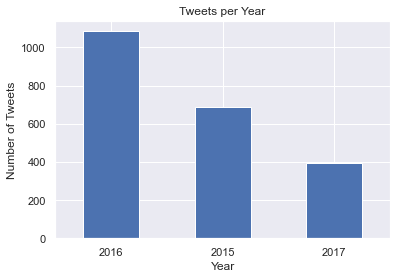

In [67]:
we_rate_dogs_clean.timestamp.dt.year.value_counts().plot(kind='bar', 
                                                rot=0,
                                                ).set(title='Tweets per Year', 
                                                     xlabel='Year', 
                                                     ylabel='Number of Tweets', 
                                                    );

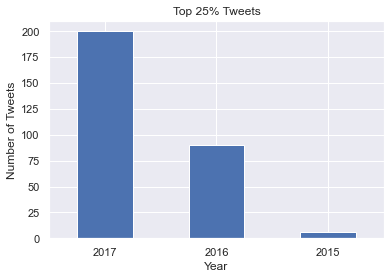

In [68]:
top_25_pc.timestamp.dt.year.value_counts().plot(kind='bar', 
                                                rot=0,
                                                ).set(title='Top 25% Tweets', 
                                                     xlabel='Year', 
                                                     ylabel='Number of Tweets', 
                                                    );

######  Tweets per Month - Top Five

For the whole dataset, we'll look at tweet production  
For the top 25 tweets, we'll look at which months had the highest engagement.

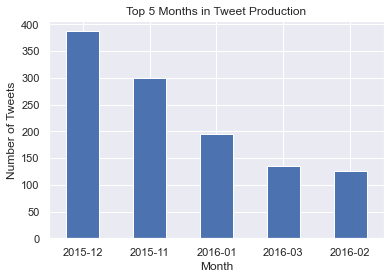

In [69]:
we_rate_dogs_clean.timestamp.dt.to_period('M').value_counts()[:5].plot(kind='bar', 
                                                rot=0,
                                                ).set(title='Top 5 Months in Tweet Production', 
                                                     xlabel='Month', 
                                                     ylabel='Number of Tweets',
                                                    );

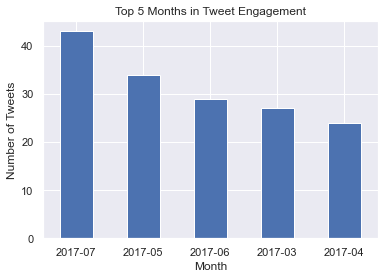

In [70]:
top_25_pc.timestamp.dt.to_period('M').value_counts()[:5].plot(kind='bar', 
                                                rot=0,
                                                ).set(title='Top 5 Months in Tweet Engagement', 
                                                     xlabel='Month', 
                                                     ylabel='Number of Tweets',
                                                    );

######  Most Clear Images

We'll see which image (first, second, third or fourth) as attached in the tweet produced the best dog prediction

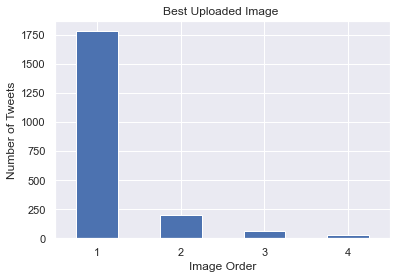

In [71]:
img_pred_clean.img_num.value_counts().plot(kind='bar', 
                                                rot=0,
                                                ).set(title='Best Uploaded Image ', 
                                                     xlabel='Image Order', 
                                                     ylabel='Number of Tweets',
                                                    );

######  Most Common Dog Breeds - Top Five

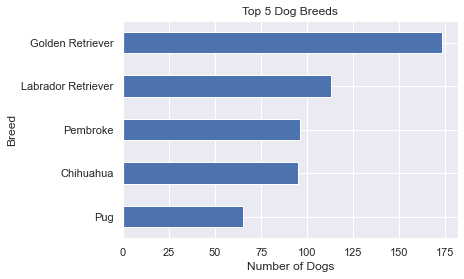

In [72]:
we_rate_dogs_clean.dog_breed.value_counts()[:5].sort_values().plot(kind='barh', 
                                                                    rot=0,
                                                                    ).set(title='Top 5 Dog Breeds', 
                                                                         ylabel='Breed', 
                                                                         xlabel='Number of Dogs',
                                                                        );

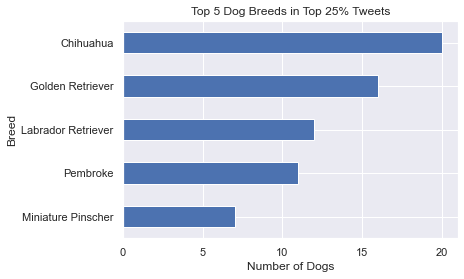

In [73]:
top_25_pc.dog_breed.value_counts()[:5].sort_values().plot(kind='barh', 
                                                                    rot=0,
                                                                    ).set(title='Top 5 Dog Breeds in Top 25% Tweets', 
                                                                         ylabel='Breed', 
                                                                         xlabel='Number of Dogs',
                                                                         xticks=[0,5,10,15,20],                                                                        
                                                                        );

######  Dog stages

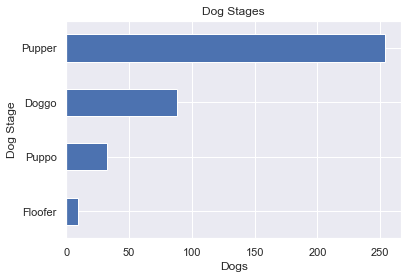

In [74]:
we_rate_dogs_clean.dog_stage.value_counts().sort_values().plot(kind='barh', 
                                                                    rot=0,
                                                                    ).set(title='Dog Stages', 
                                                                         ylabel='Dog Stage', 
                                                                         xlabel='Dogs',                                                                       
                                                                        );

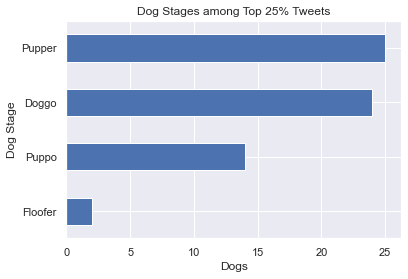

In [75]:
top_25_pc.dog_stage.value_counts().sort_values().plot(kind='barh', 
                                                                    rot=0,
                                                                    ).set(title='Dog Stages among Top 25% Tweets', 
                                                                         ylabel='Dog Stage', 
                                                                         xlabel='Dogs',                                                                       
                                                                        );

###### Ratings

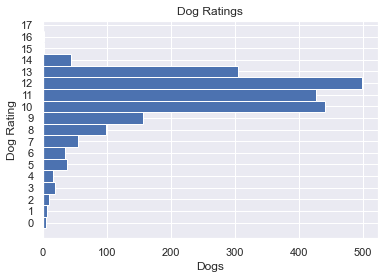

In [76]:
we_rate_dogs_clean.rating_numerator.dropna().astype(int).plot(kind='hist',
                                                              bins=np.arange(0,18,1),
                                                              yticks=np.arange(0,18,1),
                                                              orientation='horizontal',
                                                              align='left',
                                                              #figsize=(8,6)
                                                             ).set(title='Dog Ratings', 
                                                                   ylabel='Dog Rating', 
                                                                   xlabel='Dogs',
                                                                 );

###### Distribution of Social Media Engagement Metrics

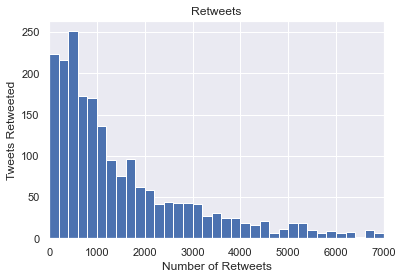

In [77]:
we_rate_dogs_clean.retweet_count.plot(kind='hist', 
                                      title='Retweets',
                                      xlim=[0,7000], 
                                      bins=np.arange(0,we_rate_dogs_clean.retweet_count.max()+200,200),
                                     ).set(title='Retweets', 
                                           xlabel='Number of Retweets', 
                                           ylabel='Tweets Retweeted',
                                          );

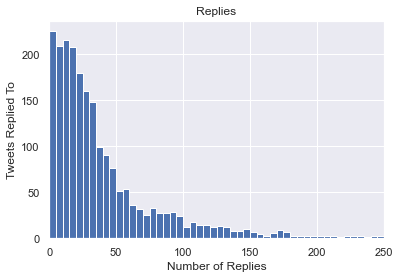

In [78]:
we_rate_dogs_clean.reply_count.plot(kind='hist', 
                                    xlim=[0,250], 
                                    bins=np.arange(0,we_rate_dogs_clean.reply_count.max()+5,5),
                                   ).set(title='Replies', 
                                         xlabel='Number of Replies',
                                         ylabel='Tweets Replied To',
                                        );

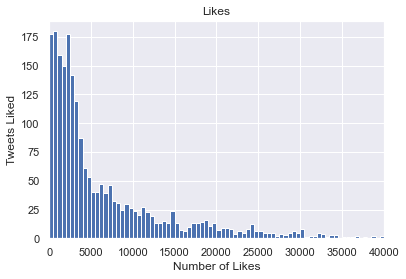

In [79]:
we_rate_dogs_clean.like_count.plot(kind='hist', 
                                   bins=np.arange(0,we_rate_dogs_clean.like_count.max()+500,500),
                                   xlim=[0,40000]
                                   ).set(title='Likes', 
                                         xlabel='Number of Likes', 
                                         ylabel='Tweets Liked',
                                        );

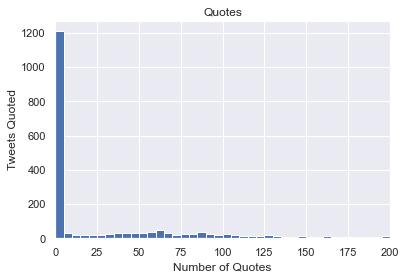

In [80]:
we_rate_dogs_clean.quote_count.plot(kind='hist', 
                                   bins=np.arange(0,we_rate_dogs_clean.quote_count.max()+5,5),
                                   xlim=[0,200]
                                   ).set(title='Quotes', 
                                         xlabel='Number of Quotes', 
                                         ylabel='Tweets Quoted',
                                        );